In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import regex as re
from pathlib import Path
from importlib import reload
from pprint import pp
from collections import Counter

In [29]:
import utils as u
import analysis as a

In [30]:
# Call to reload an imported module if it has been updated
reload(a)

<module 'analysis' from '/home/rimov/Documents/Course Material/Assignments/m450/reddit-assortativity-analysis/analysis.py'>

In [4]:
%matplotlib notebook
plt.rcParams.update({'axes.titlesize': 'large'})

In [5]:
data_path = Path('data/chain_networks')
data_path.exists()

True

In [6]:
subreds_raw = dict()

In [7]:
# All the subreddits and their paths
subreddits_paths = [sr for sr in data_path.iterdir()]
subreddits = [sr.stem for sr in data_path.iterdir()]
sorted(subreddits)

['2007scape',
 '240sx',
 '24hoursupport',
 '3DS',
 '3Dprinting',
 '3amjokes',
 '3dsFCswap',
 '49ers',
 '4chan',
 '4x4',
 '90daysgoal',
 '911truth',
 'ABDL',
 'ABraThatFits',
 'ACMilan',
 'ACTrade',
 'ADHD',
 'AFL',
 'AMA',
 'ANormalDayInRussia',
 'AbandonedPorn',
 'Accounting',
 'ActionFigures',
 'Adelaide',
 'AdoptMyVillager',
 'Advice',
 'AdviceAnimals',
 'AfterEffects',
 'AirForce',
 'Albany',
 'Albuquerque',
 'Aleague',
 'AlienBlue',
 'AllThingsTerran',
 'AmIFreeToGo',
 'AmISexy',
 'Amateur',
 'AmateurArchives',
 'AmericanHorrorStory',
 'Amsterdam',
 'Anarchism',
 'Anarcho_Capitalism',
 'Anarchy101',
 'Android',
 'AndroidGaming',
 'AndroidQuestions',
 'AnimalCrossing',
 'AnimalsBeingBros',
 'AnimalsBeingJerks',
 'AnimeFigures',
 'AnimeSketch',
 'Animesuggest',
 'AnnArbor',
 'AntiJokes',
 'Anticonsumption',
 'Anxiety',
 'AnythingGoesNews',
 'AppHookup',
 'AppalachianTrail',
 'Aquariums',
 'ArcherFX',
 'Archery',
 'Argentinacirclejerk',
 'Art',
 'ArtisanVideos',
 'ArtistLounge',
 'As

#### Non-political Subreddits by Group:
Analysis of political subreddits must be compared to other groups in order to observe any trends. Ideally I would find a group of subreddits that are as closely resembling of natural social groups as possible, so as to perhaps show that advice-giving subreddits or those dealing with sensitive topics (eg. politics, sports) show great homophilic tendincies or high betweenness. This would support the hypothesis that reddit is not a great place to turn to for advice or gaining perspective, as the communities that purport to do that are biased.

The groups chosen to be sampled are those related to: 
<ul>
    <li>gaming: 
        <ul>
            <li>CrusaderKings</li>
            <li>Diablo</li>
            <li>GTAV</li>
            <li>2007scape</li>
            <li>HalfLife</li>
        </ul>
    </li>
    <li>geographical(dedicated to specific cities/countries): 
        <ul>
            <li>Amsterdam</li>
            <li>Brooklyn</li>
            <li>Hawaii</li>
            <li>Israel</li>
            <li>LosAngeles</li>
        </ul>
    </li>
    <li>medicine(dedicated to certain mental or physical conditions): 
        <ul>
            <li>ChronicPain</li>
            <li>Fibromyalgia</li>
            <li>alcoholism</li>
            <li>bipolar</li>
            <li>socialanxiety</li>
        </ul>
    </li>
    <li>sports: 
        <ul>
            <li>Bowling</li>
            <li>Kayaking</li>
            <li>nyjets</li>
            <li>powerlifting</li>
            <li>lacrosse</li>
        </ul>
    </li>
    <li>religion: 
        <ul>
            <li>Catholicism</li>
            <li>Christianity</li>
            <li>Buddhism</li>
            <li>Judaism</li>
            <li>islam</li>
        </ul>
    </li>
    <li>QA/advice: 
        <ul>
            <li>AskEngineers</li>
            <li>askphilosophy</li>
            <li>AskFeminists</li>
            <li>AskNYC</li>
            <li>AskPhotography</li>
        </ul>
    </li>
</ul>

Each group will have at most 5 subreddits, as combing through ~2000 subreddits and partitioning each is very time-consuming. Choosing of the subreddits was done by simply scrolling through an alphabetically-ordered list and choosing based on recognition or personal preference (thought subreddit X was more representative of the selected group than subreddit Y) -- therefore the choice was not random and **is biased**. Analyzing subreddits with >1 million members would be too computationally-demanding to perform calculations on, so I restricted focus to the smaller ones, which could be a bit more niche and perhaps in some way bias the results.

In [8]:
topics_game = ['CrusaderKings', 'Diablo', 'GTAV', '2007scape', 'HalfLife']
topics_geo = ['Amsterdam', 'Brooklyn', 'Hawaii', 'Israel', 'LosAngeles']
topics_med = ['ChronicPain', 'Fibromyalgia', 'alcoholism', 'bipolar', 'socialanxiety']
topics_sport = ['Bowling', 'Kayaking', 'nyjets', 'powerlifting', 'lacrosse']
topics_religion = ['Catholicism', 'Christianity', 'Buddhism', 'Judaism', 'islam']
topics_ask = ['AskEngineers', 'askphilosophy', 'AskFeminists', 'AskNYC', 'AskPhotography']

In [9]:
paths_game = [data_path/f'{topic}.json' for topic in topics_game]
paths_geo = [data_path/f'{topic}.json' for topic in topics_geo]
paths_med = [data_path/f'{topic}.json' for topic in topics_med]
paths_sport = [data_path/f'{topic}.json' for topic in topics_sport]
paths_religion = [data_path/f'{topic}.json' for topic in topics_religion]
paths_ask = [data_path/f'{topic}.json' for topic in topics_ask]

In [10]:
paths = {'game': paths_game, 'geo': paths_geo, 'med': paths_med, 'sport': paths_sport, 'religion': paths_religion, 'ask': paths_ask}

In [11]:
paths_valid = []

for ps in paths.values():
    paths_valid.append([(sr.stem, sr in subreddits_paths) for sr in ps])
    
paths_valid

[[('CrusaderKings', True),
  ('Diablo', True),
  ('GTAV', True),
  ('2007scape', True),
  ('HalfLife', True)],
 [('Amsterdam', True),
  ('Brooklyn', True),
  ('Hawaii', True),
  ('Israel', True),
  ('LosAngeles', True)],
 [('ChronicPain', True),
  ('Fibromyalgia', True),
  ('alcoholism', True),
  ('bipolar', True),
  ('socialanxiety', True)],
 [('Bowling', True),
  ('Kayaking', True),
  ('nyjets', True),
  ('powerlifting', True),
  ('lacrosse', True)],
 [('Catholicism', True),
  ('Christianity', True),
  ('Buddhism', True),
  ('Judaism', True),
  ('islam', True)],
 [('AskEngineers', True),
  ('askphilosophy', True),
  ('AskFeminists', True),
  ('AskNYC', True),
  ('AskPhotography', True)]]

In [12]:
all([p[1] for p in paths])

True

## Surface Analysis:
Will do this a group at a time to not overload the RAM.

### Game

In [13]:
nets = dict([u.digraph_from_path(p.stem, p) for p in paths['game']])
nets

{'CrusaderKings': <networkx.classes.digraph.DiGraph at 0x7ff8376a5d80>,
 'Diablo': <networkx.classes.digraph.DiGraph at 0x7ff92e17ac50>,
 'GTAV': <networkx.classes.digraph.DiGraph at 0x7ff8376a5d50>,
 '2007scape': <networkx.classes.digraph.DiGraph at 0x7ff83a723400>,
 'HalfLife': <networkx.classes.digraph.DiGraph at 0x7ff8376a5ab0>}

In [28]:
params_game = a.get_graph_base_stats(nets)
params_game

,nodes,edges,density,nodes_largest_strong_comp,pct_nodes_largest_strong_comp,nodes_deg_one,pct_nodes_deg_one,pagerank_max,pagerank_avg,reciprocity
CrusaderKings,7738,26367,0.000440,2394,0.309382,1612,0.208323,0.008198,0.000129,0.151553
Diablo,32420,107055,0.000102,10522,0.324553,6843,0.211073,0.008867,0.000031,0.098024
GTAV,8470,19440,0.000271,1902,0.224557,2334,0.275561,0.006093,0.000118,0.203909
2007scape,13285,58847,0.000333,4316,0.324878,3025,0.227700,0.007487,0.000075,0.177375
HalfLife,2844,6115,0.000756,463,0.162799,803,0.282349,0.023426,0.000352,0.156664


In [31]:
# Normalize the node, edge, and density values for each subreddit relative to
#   total sum across all the subreddits
normalized_params = a.normalize_over_sum(params_game, sort_by=['nodes', 'edges'])
normalized_params

,nodes,edges,density,nodes_largest_strong_comp,pct_nodes_largest_strong_comp,nodes_deg_one,pct_nodes_deg_one,pagerank_max,pagerank_avg,reciprocity
Diablo,0.500641,0.491475,0.053628,0.536919,0.241094,0.468154,0.175164,0.163986,0.043750,0.124471
2007scape,0.205152,0.270158,0.175079,0.220238,0.241335,0.206951,0.188962,0.138474,0.106765,0.225231
GTAV,0.130797,0.089246,0.142482,0.097056,0.166812,0.159677,0.228680,0.112678,0.167459,0.258924
CrusaderKings,0.119493,0.121047,0.231335,0.122162,0.229824,0.110283,0.172881,0.151608,0.183300,0.192442
HalfLife,0.043918,0.028073,0.397476,0.023626,0.120935,0.054936,0.234313,0.433253,0.498726,0.198932


In [43]:
plt.clf()

<IPython.core.display.Javascript object>


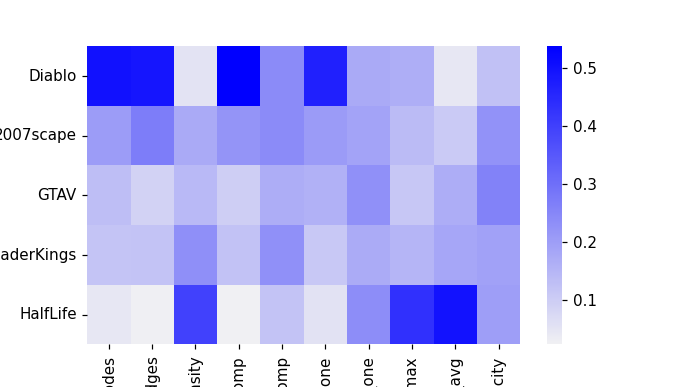

In [44]:
fig, ax = plt.subplots(figsize=(6,3))

In [45]:
plt.cla()
sns.heatmap(normalized_params, cmap=sns.color_palette("light:b", as_cmap=True))

<AxesSubplot: >

In [47]:
plt.savefig('images/base-stats-normalized.png', bbox_inches='tight')

### Strong Component Analysis

In [48]:
# For later analyses
strongest_comps = a.get_subset_strongly_conn_components(nets, True)
strongest_game = [nets[n].subgraph(strongest_comps[n]) for n in nets.keys()]

In [22]:
params_strong_game = 

SyntaxError: invalid syntax (2342907899.py, line 1)

## Centrality:

## Reciprocity:

## Random Graphs: